# Homework 11

In class, we discussed various forms of position embeddings for self-attention in Transformers. One kind of position embedding we discussed in class is a relative position embedding, where we associate each offset $\Delta = t - i$ between position query position $t$ and key position $i$ with a scalar $e_\Delta$ that gets added to the output of the comparison function as $\alpha(q_t, k_i) + e_\Delta$. This is the type of position embedding used in [ALIBI](https://arxiv.org/abs/2108.12409) and [T5](https://arxiv.org/abs/2108.12409).

# Problem 1

In the T5 model, there is a single set of attention "bias" values ($e_\Delta$) shared across all layers in the encoder (and another set shared across all layers in the decoder). Each attention head (of which there are 12)has its own set of bias values. The offsets in the bias values are logarithmically spaced, and there are 32 total bias values.

Below you will find code for loading the [`t5-base`](https://huggingface.co/t5-base) model from the Hugging Face Model Hub and grabbing the tensor for the attention biases in the encoder. You'll also find a funcion that maps from an offset ($\Delta$) and returns an index into the attention bias tensor. So, for example, if you wanted to get the bias for query index `t` and key index `i`, you could do `biases[relative_position_bucket(t - i)]`.

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.6 MB/s eta 0:00:00


In [3]:
from transformers import T5Model
import torch
import math

def relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
    """
    Adapted from Mesh Tensorflow:
    https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593
    Translate relative position to a bucket number for relative attention. The relative position is defined as
    memory_position - query_position, i.e. the distance in tokens from the attending position to the attended-to
    position. If bidirectional=False, then positive relative positions are invalid. We use smaller buckets for
    small absolute relative_position and larger buckets for larger absolute relative_positions. All relative
    positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
    This should allow for more graceful generalization to longer sequences than the model has been trained on
    Args:
        relative_position: an int32 Tensor
        bidirectional: a boolean - whether the attention is bidirectional
        num_buckets: an integer
        max_distance: an integer
    Returns:
        a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
    """
    relative_buckets = 0
    if bidirectional:
        num_buckets //= 2
        relative_buckets += (relative_position > 0).to(torch.long) * num_buckets
        relative_position = torch.abs(relative_position)
    else:
        relative_position = -torch.min(relative_position, torch.zeros_like(relative_position))
    # now relative_position is in the range [0, inf)

    # half of the buckets are for exact increments in positions
    max_exact = num_buckets // 2
    is_small = relative_position < max_exact

    # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
    relative_position_if_large = max_exact + (
        torch.log(relative_position.float() / max_exact)
        / math.log(max_distance / max_exact)
        * (num_buckets - max_exact)
    ).to(torch.long)
    relative_position_if_large = torch.min(
        relative_position_if_large, torch.full_like(relative_position_if_large, num_buckets - 1)
    )

    relative_buckets += torch.where(is_small, relative_position, relative_position_if_large)
    return relative_buckets


model = T5Model.from_pretrained("t5-base")
biases = model.get_parameter("encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight").detach().numpy()

1. Using this tensor and function, plot images (e.g. using plt.imshow) that show the relative attention bias for each offset. Your x-axis should be the query index from 0 to 128, your y-axis should be the key index from 0 to 128, and the color in the image should represent the bias.

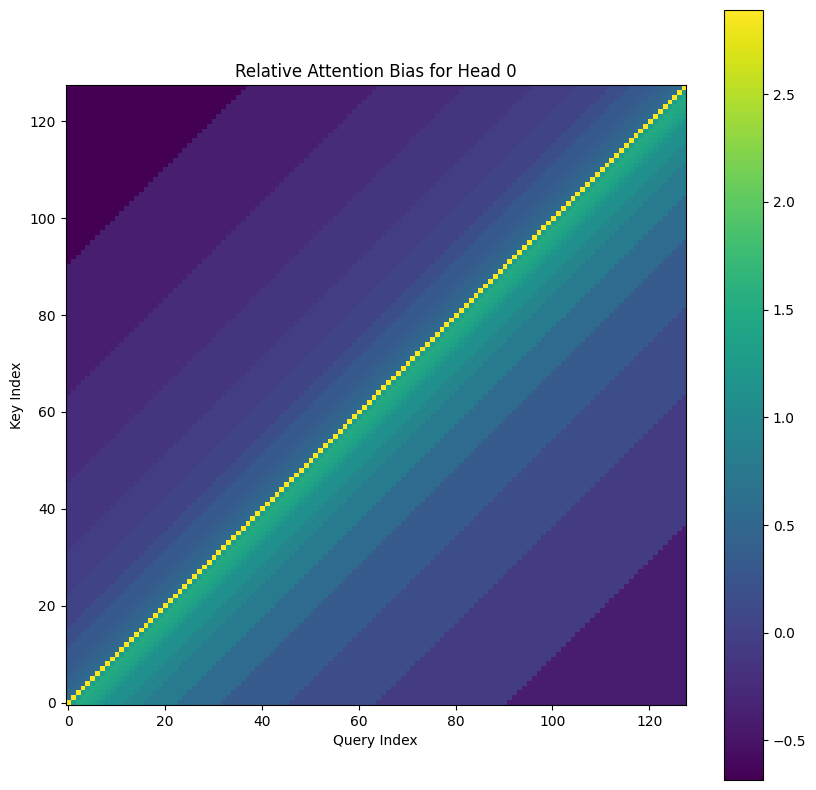

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def create_bias_matrix(biases, max_sequence_length=128):
    bias_matrix = np.zeros((max_sequence_length, max_sequence_length))

    for t in range(max_sequence_length):
        for i in range(max_sequence_length):
            # Convert the input to a tensor
            relative_position = torch.tensor(t - i, dtype=torch.long)
            index = relative_position_bucket(relative_position).item()
            bias_matrix[i, t] = biases[index]  # Switch indices i and t

    return bias_matrix

head_index = 0
head_biases = biases[:, head_index]

bias_matrix = create_bias_matrix(head_biases)

plt.figure(figsize=(10, 10))
plt.imshow(bias_matrix, cmap='viridis', origin='lower')
plt.colorbar()
plt.xlabel('Query Index')  # x-axis
plt.ylabel('Key Index')    # y-axis
plt.title('Relative Attention Bias for Head {}'.format(head_index))
plt.show()

2. Pick one of the bias images for one of the heads that looks interpretable and explain what it is causing the model to do (i.e. which positions is it increasing or decreasing the attention values for).

As we can see from the plot, the colors represent the attention bias, with lighter colors (yellow) indicating higher values and darker colors (blue) indicating lower values. The x-axis represents the query index and the y-axis represents the key index. In the context of the T5 model, the key index represents the memory tokens the model is attending to, while the query index represents the current token the model is focusing on. In the above-biased image of the 0 head, we can find that the lighter colors are concentrated on the diagonal line from the lower left to the upper right corner and below the diagonal line. This pattern could indicate that the model is encouraged to pay attention to nearby positions with close query and key indices (along the diagonal) and positions that occur before the current token (below the diagonal), meaning that it prefers to pay more attention to the local context around the current token and past tokens. The darker colors (lower biases) above the diagonal suggest that the model has lower attention values for tokens that appear after the current token. 

# Problem 2

Consider a one-dimensional convolution of a filter $[w_1, w_2, w_3]$ against a sequence $[x_1, x_2, x_3, x_4]$ with a padding of 1 and stride of 1. The output of this convolution is
\begin{align}
 [&w_2 x_1 + w_3 x_2, \\
 &w_1 x_1 + w_2 x_2 + w_3 x_3, \\
 &w_1 x_2 + w_2 x_3 + w_3 x_4, \\
 &w_1 x_3 + w_2 x_4] \end{align}
In addition, consider the general form of the "relative attention bias" approach, where $ e_\Delta$ gets added to the output of the comparison function as $\alpha(q_t, k_i) + e_\Delta$. Design an attention mechanism using relative attention bias that produces the same output the convolution described above. You can set $e_\Delta$ however you choose, i.e. don't assume they are learned. Hint: Remember, you also get to decide what the queries, keys, values, comparison function, and reduction function are. They can be whatever you want! E.g. the reduction function doesn't need to have a softmax and the comparison function's output can be constant.

**Setting**

We can set the queries(Q), keys(K), and values(V) which are same as input sequence: 
  * Q = [x1, x2, x3, x4]
  * K = [x1, x2, x3, x4]
  * V = [x1, x2, x3, x4]

The comparison function is 𝛼(q,k) = q * k (dot production) and the reduction function is weighted sum. 
In order to match the positions in the convolution operation, we set the relative attention bias indices to be 0, 1, and -1.
  * $e_{0}$ = w2
  * $e_{1}$ = w3
  * $e_{-1}$ = w1

**Calculation**

For x1: 
  * 𝛼(x1,x1)=$x1^2$, 𝛼(x1,x2)=x1*x2
  * output=w2̇\*$x1^2$+w3\*x1*x2

For x2: 
  * 𝛼(x2,x1)=x2\*x1, 𝛼(x2,x2)=$x2^2$, 𝛼(x2,x3)=x2*x3
  * output=w1\*x2\*x1+w2\*$x2^2$+w3\*x2*x3

For x3: 
  * 𝛼(x3,x2)=x3\*x2, 𝛼(x3,x3)=$x3^2$, 𝛼(x3,x4)=x3*x4
  * output=w1\*x3\*x2+w2\*$x3^2$+w3\*x3*x4

For x4: 
  * 𝛼(x4,x3)=x4*x3, 𝛼(x4,x4)=$x4^2$
  * output=w1\*x4\*x3+w2*$x4^2$

The output of attention mechanism using relative attention bias is same as the given convolution: 
\begin{align}
 [&w_2 x_1^2+ w_3 x_1 x_2, \\
 &w_1 x_2 x_1 + w_2 x_2^2 + w_3 x_2 x_3, \\
 &w_1 x_3 x_2 + w_2 x_3^2 + w_3 x_3 x_4, \\
 &w_1 x_4 x_3 + w_2 x_4^2] \end{align}


In [6]:
def attention_mechanism(x, w, e):
    Q = K = V = x.unsqueeze(2)
    alpha = torch.bmm(Q, K.transpose(1, 2))

    # Add relative attention bias
    seq_len = x.shape[1]
    for t in range(seq_len):
        for i in range(seq_len):
            delta = t - i
            if delta in e:
                alpha[:, t, i] += e[delta]

    # Weighted sum without softmax
    output = torch.bmm(alpha, V)
    return output.squeeze(2)

x = torch.tensor([[1.0, 2.0, 3.0, 4.0]])  # Input sequence
w = torch.tensor([1.0, 2.0, 3.0])  # Filter
e = {0: w[1], 1: w[2], -1: w[0]}  # Relative attention bias

result = attention_mechanism(x, w, e)
print(result)

tensor([[ 34.,  70., 106., 137.]])
